<a href="https://colab.research.google.com/github/aknur-abdikarimova/AMD_FindingSimilarItems/blob/main/AMD_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 — Finding Similar Book Reviews

**Goal:** Detect pairs of *similar* (including identical) book reviews based on the fields `review/text` and `review/summary` from the `Amazon Book Reviews` dataset using **shingling**, **MinHash**, and **Locality Sensitive Hashing (LSH)**.

## Pipeline
0. Setup and library imports
1. Set configuration and constants
2. Define helper functions for text preprocessing and similarity computation
3. Load and prepare dataset  
4. Do cleaning and filtering of reviews
5. Normalization and Shingling
6. MinHash Signatures and LSH Index
7. Retrieve Candidate Pairs and Compute Exact Jaccard
8. Report and Examples
9. Visualizations of Results
10. Cross-Title Duplicate Check for additional analysis



## Setup and Library Imports

This section installs and imports all required libraries for the project.  
It includes text preprocessing tools (`nltk`, `langdetect`), hashing and similarity libraries (`mmh3`, `datasketch`), and visualization tools (`matplotlib`, `seaborn`).  
Also downloads the NLTK resources (stopwords and lemmatizer) needed for normalization.


In [1]:
!pip install kaggle pandas datasketch mmh3 tqdm nltk langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 6.7 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=4fff72699ab279089857846c336df1978f6e2bf0db77b5e439d03fa1eaf441eb
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [2]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [27]:
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
!unzip -n amazon-books-reviews.zip


Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
amazon-books-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  amazon-books-reviews.zip


In [28]:
import re
from pathlib import Path
from typing import List, Set, Tuple, Iterable, Dict
from collections import Counter

import pandas as pd
import mmh3
from datasketch import MinHash, MinHashLSH
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from langdetect import detect, DetectorFactory
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Step 1 - Configuration and Constants

This section defines all global parameters in one place:
- File paths and column mappings  
- Sampling and text length thresholds  
- Parameters for shingling, MinHash, and LSH  
- Cutoffs for filtering overly common shingles (similar to IDF)
  
This ensures reproducibility and allows easy tuning of performance vs. accuracy.


In [29]:
INPUT_PATH = Path("Books_rating.csv")

COLUMNS_MAP = {
    "id": "Id",
    "title": "Title",
    "score": "review/score",
    "summary": "review/summary",
    "text": "review/text",
}

NROWS       = 100_000
SAMPLE_SIZE = 30_000

# text filters
MIN_WORDS   = 5
LANG_MINLEN = 20

# shingles & MinHash/LSH
K_SHINGLE   = 3
NUM_PERM    = 64
THRESHOLD   = 0.60
MAX_CANDIDATES_PER_DOC = 500
SEED        = 42

# filter for common shingles
MAX_DF      = 0.10


## Step 2️ - Helper Functions

This section defines helper functions for text preprocessing and similarity computation:
- `clean_text`: removes punctuation, HTML tags, and lowercases text  
- `is_english`: detects and keeps only English reviews  
- `tokenize`, `lemmatize_en`, `remove_stopwords`: normalize text  
- `make_shingles`: generates shingles
- `hash_shingle`: converts shingles into stable 64-bit hashes  
- `jaccard`: computes exact Jaccard similarity  
- `categorize`: groups review pairs into similarity categories (duplicate, near-duplicate, etc.)


In [30]:
clean_re = re.compile(r"<[^>]+>|[^a-zA-Z0-9]+", re.UNICODE)
en_stop = set(stopwords.words("english")) | {"n't", "'s", "'re"}

def clean_text(s: str) -> str:
    """this function removes punctuation, HTML tags, and lowercases text"""
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = clean_re.sub(" ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def is_english(text: str, min_len: int = LANG_MINLEN) -> bool:
    """this function detects if text is in English and long enough for detection"""
    if not text or len(text) < min_len:
        return False
    try:
        return detect(text) == "en"
    except Exception:
        return False

def tokenize(s: str) -> List[str]:
    """this function splits text by whitespace"""
    return s.split()

def lemmatize_en(tokens: List[str]) -> List[str]:
    """this function does simple lemmatization: verb then noun pass"""
    out: List[str] = []
    for t in tokens:
        t = WordNetLemmatizer().lemmatize(t, pos="v")
        t = WordNetLemmatizer().lemmatize(t, pos="n")
        out.append(t)
    return out

def remove_stopwords(tokens: List[str]) -> List[str]:
    """this function drops English stopwords and 1-char tokens"""
    return [t for t in tokens if t not in en_stop and len(t) > 1]

def make_shingles(tokens: List[str], k: int) -> List[Tuple[str, ...]]:
    """this function makes shingles"""
    if k <= 0 or len(tokens) < k:
        return []
    return [tuple(tokens[i:i+k]) for i in range(len(tokens) - k + 1)]

def jaccard(a: Set[int], b: Set[int]) -> float:
    """this function calculates Jaccard similarity of two reviews"""
    if not a and not b:
        return 0.0
    inter = len(a & b)
    union = len(a | b)
    return inter / union if union else 0.0

def categorize(sim: float) -> str:
    """this function divides reviews into categories based on Jaccard similarity score"""
    if sim >= 1.0: return "duplicate"
    if sim >= 0.9:  return "near-duplicate"
    if sim >= 0.8:  return "high-similarity"
    if sim >= 0.7:   return "related"
    if sim >= THRESHOLD:     return "loose"
    return "below-threshold"

def hash_shingle(s_tuple: Tuple[str, ...]) -> int:
    """this function creates stable 64-bit hash for a shingle tuple"""
    return mmh3.hash64("|".join(s_tuple), signed=False)[0]

## Step 3 - Load and Prepare Dataset

This section reads the dataset (`Books_rating.csv`) and extracts only the necessary columns.  
The columns `review/summary` and `review/text` are merged into a single column `text`.  
This merged text will later be used for tokenization and similarity analysis.


In [31]:
usecols = list(COLUMNS_MAP.values())
df = (
    pd.read_csv(INPUT_PATH, nrows=NROWS, usecols=usecols)
      .rename(columns={v: k for k, v in COLUMNS_MAP.items()})
)

df["text"] = (df["summary"].fillna("").astype(str) + " " +
              df["text"].fillna("").astype(str)).str.strip()

df = df[["id", "title", "score", "text"]]

## Step 4 - Cleaning and Filtering Reviews

This section cleans the merged text using `clean_text`, filters out very short reviews, and keeps only English texts.  
Also samples a subset of the dataset to speed up processing.  
The resulting DataFrame `df` contains only relevant, clean English reviews.


In [32]:

df["text"] = df["text"].apply(clean_text) # text = cleaned text
df["n_words"] = df["text"].str.split().map(len)
df = df[df["n_words"] >= MIN_WORDS].copy()

df["is_en"] = df["text"].apply(is_english)
df = df[df["is_en"]].drop(columns=["is_en"]).reset_index(drop=True)

if SAMPLE_SIZE is not None and len(df) > SAMPLE_SIZE:
    df = df.sample(n=SAMPLE_SIZE, random_state=SEED).reset_index(drop=True)

print(f"Documents after EN filtering: {len(df)}")
display(df.head(3))


Documents after EN filtering: 30000


,id,title,score,text,n_words
0,B0001GDR3U,The Last Juror,5.0,this is the john i fell in love with yes we return the brooding town of clanton for a thriller with heart that reminds me of the passion that made a time to kill and the firm such great books dann...,162
1,0966640403,A Search for Meaning: The Story of Rex,5.0,breathtakingly beautiful book an amazingly beautiful illustrated book i went through cover to cover looking at only the illustrations then i ve read it through a couple of times what a great story...,67
2,074325144X,"Chi Running: A Revolutionary Approach to Effortless, Injury-Free Running",5.0,life changing i have been a runner for years for excercise this book has taught me how to take it to the next level so far i have gone from running for 30 minutes to an hour,37


## Step 5️ - Normalization and Shingling

Each review is tokenized, lemmatized, and stripped of stopwords.  
Then generates **shingles** (word sequences of length `K_SHINGLE`) for each document.  
To avoid noise, shingles that appear in more than `MAX_DF` proportion of documents are filtered out.


In [33]:

tokens_list: List[List[str]] = []
for t in df["text"].tolist():
    toks = tokenize(t)
    toks = lemmatize_en(toks)
    toks = remove_stopwords(toks)
    tokens_list.append(toks)

print(f"Normalized {len(tokens_list)} texts")

doc_shingles: List[Set[Tuple[str, ...]]] = []
df_counter: Counter = Counter()

for toks in tokens_list:
    sh = make_shingles(toks, K_SHINGLE)
    sh_set = set(sh)
    doc_shingles.append(sh_set)
    for s in sh_set:
        df_counter[s] += 1

N_docs = len(doc_shingles)
cutoff = max(1, int(MAX_DF * N_docs))
too_common = {s for s, c in df_counter.items() if c >= cutoff}

print(f"Total unique shingles: {len(df_counter)}")
print(f"Too common shingles:   {len(too_common)} (cutoff = {cutoff} docs)")


Normalized 30000 texts
Total unique shingles: 2058507
Too common shingles:   0 (cutoff = 3000 docs)


## Step 6 - MinHash Signatures and LSH Index

This sections computes one MinHash signature per review to efficiently approximate similarity.  
Then builds a **Locality Sensitive Hashing (LSH)** index, which allows fast lookup of candidate pairs of potentially similar documents.  
This reduces computation from O(n²) comparisons to roughly linear time.


In [34]:
hashed_sets: List[Set[int]] = []
minhashes: List[MinHash] = []

for sh_set in doc_shingles:
    filtered: Iterable[Tuple[str, ...]] = (s for s in sh_set if s not in too_common)
    hset = {hash_shingle(s) for s in filtered}
    hashed_sets.append(hset)

    m = MinHash(num_perm=NUM_PERM)
    for h in hset:
        m.update(int(h).to_bytes(8, byteorder="little", signed=False))
    minhashes.append(m)

lsh = MinHashLSH(threshold=THRESHOLD, num_perm=NUM_PERM)
for i, m in enumerate(minhashes):
    lsh.insert(f"doc:{i}", m)




## Step 7 - Retrieve Candidate Pairs and Compute Exact Jaccard

Using the LSH index, this section retrieves candidate pairs for each review.  
For each candidate, the exact Jaccard similarity is calculated using hashed shingles.  
Pairs exceeding the similarity threshold are stored for analysis.


In [35]:

def find_candidates(lsh_index: MinHashLSH, mhash: MinHash, self_idx: int) -> List[int]:
    """Return neighbor indices for document self_idx (exclude itself)."""
    res = lsh_index.query(mhash)
    return [int(tag.split(":")[1]) for tag in res if tag != f"doc:{self_idx}"]

seen_pairs: Set[Tuple[int, int]] = set()
pairs: List[Tuple[int, int, float]] = []

for i, m in enumerate(minhashes):
    cand = find_candidates(lsh, m, i)
    if MAX_CANDIDATES_PER_DOC and len(cand) > MAX_CANDIDATES_PER_DOC:
        cand = cand[:MAX_CANDIDATES_PER_DOC]
    for j in cand:
        a, b = (i, j) if i < j else (j, i)
        if (a, b) in seen_pairs:
            continue
        seen_pairs.add((a, b))
        sim = jaccard(hashed_sets[a], hashed_sets[b])
        if sim >= THRESHOLD:
            pairs.append((a, b, sim))

print(f"Found {len(pairs)} candidate pairs with Jaccard ≥ {THRESHOLD}")

Found 831 candidate pairs with Jaccard ≥ 0.6


## Step 8 - Small Report and Examples

All detected pairs are assembled into a single DataFrame `pairs_df` containing:
- Review IDs, titles, scores, and texts for each pair  
- The computed Jaccard similarity  
- The assigned similarity category  

This section prints summary statistics and displays **five examples** for each category.


In [36]:
rows = []
for a, b, sim in sorted(pairs, key=lambda x: x[2], reverse=True):
    ra, rb = df.iloc[a], df.iloc[b]
    rows.append({
        "a_idx": a, "b_idx": b,
        "jaccard": round(sim, 4),
        "category": categorize(sim),
        "id1": str(ra.get("id", "")),   "title1": str(ra.get("title", "")),
        "score1": float(ra["score"]) if pd.notna(ra.get("score")) else None,
        "text1": str(ra.get("text", "")),
        "id2": str(rb.get("id", "")),   "title2": str(rb.get("title", "")),
        "score2": float(rb["score"]) if pd.notna(rb.get("score")) else None,
        "text2": str(rb.get("text", "")),
    })
pairs_df = pd.DataFrame(rows)

print(f"Pairs kept: {len(pairs_df)}")
if pairs_df.empty:
    print("No pairs found — consider lowering THRESHOLD or adjusting K_SHINGLE/MAX_DF.")
else:
    print("\nPairs by category:")
    display(pairs_df["category"].value_counts().sort_index())

    pd.set_option("display.max_colwidth", 200)

    def show_examples(cat: str, n: int = 5) -> None:
        sub = pairs_df[pairs_df["category"] == cat].sort_values("jaccard", ascending=False).head(n)
        if sub.empty:
            print(f"\nNo examples for category '{cat}'")
            return
        print(f"\n {cat.upper()} — Top {len(sub)} examples:")
        display(sub[["jaccard", "id1", "title1", "score1", "text1",
                     "id2", "title2", "score2", "text2"]])

    for cat in ["duplicate", "near-duplicate", "high-similarity", "related", "loose"]:
        show_examples(cat, n=5)

Pairs kept: 831

Pairs by category:


,count
category,
duplicate,736
high-similarity,21
loose,8
near-duplicate,55
related,11



 DUPLICATE — Top 5 examples:


,jaccard,id1,title1,score1,text1,id2,title2,score2,text2
719,1.0,B000TZ19TC,Fahrenheit 451,4.0,amazingly relevant amazingly relevant for our times story is a little odd and wordy but it is an excellently crafted piece that will go down in history as a classic,B000GL8UMI,Fahrenheit 451,4.0,amazingly relevant amazingly relevant for our times story is a little odd and wordy but it is an excellently crafted piece that will go down in history as a classic
718,1.0,1404318372,The Mayor of Casterbridge,5.0,a classic chronicle of sin and redemption if i were ever to be an english literature teacher the mayor of casterbridge is the first book i d start with not just because it s filled with themes of ...,1404318364,"Mayor of Casterbridge, the",5.0,a classic chronicle of sin and redemption if i were ever to be an english literature teacher the mayor of casterbridge is the first book i d start with not just because it s filled with themes of ...
717,1.0,B000NWU3I4,"The Hobbitt, or there and back again; illustrated by the author.",5.0,the ultimate adventure the hobbit has always held a special place in my heart even compared to lord of the rings while the hobbit obviously doesn t go as far in depth into the history of middle ea...,B000NWU3I4,"The Hobbitt, or there and back again; illustrated by the author.",5.0,the ultimate adventure the hobbit has always held a special place in my heart even compared to lord of the rings while the hobbit obviously doesn t go as far in depth into the history of middle ea...
716,1.0,B000MZWXNA,The Martian Way,5.0,classic a good as quot foundation quot foundation and empire is the second book in this series if you have not read the first one yet you should still because of the rare and very clear writing fo...,B000PBZH6Q,Foundation,5.0,classic a good as quot foundation quot foundation and empire is the second book in this series if you have not read the first one yet you should still because of the rare and very clear writing fo...
715,1.0,B000TZ19TC,Fahrenheit 451,4.0,farhenheit 451 jessica h s review i believe that the book fahrenheit 451 was very well written and very interesting mr bradbury made the book have a lot of good vocabulary for a 12 year old to lea...,B000GL8UMI,Fahrenheit 451,4.0,farhenheit 451 jessica h s review i believe that the book fahrenheit 451 was very well written and very interesting mr bradbury made the book have a lot of good vocabulary for a 12 year old to lea...



 NEAR-DUPLICATE — Top 5 examples:


,jaccard,id1,title1,score1,text1,id2,title2,score2,text2
736,0.9905,B000NWU3I4,"The Hobbitt, or there and back again; illustrated by the author.",5.0,the story begins the hobbit or there and back again is the first story of middle earth that was ever read by the masses and to this day it remains a beloved favorite due to tolkien s exceptional w...,B000NWU3I4,"The Hobbitt, or there and back again; illustrated by the author.",5.0,and back again the hobbit or there and back again is the first story of middle earth that was ever read by the masses and to this day it remains a beloved favorite due to tolkien s exceptional wri...
737,0.9896,B000KJPK10,Roman Catholicism,1.0,a hate book written by an author with made up facts and unsubstantiated claims first off let me say that i have no ax to grind in reviewing this book because my family is lutheran and i married a ...,B000KJPK10,Roman Catholicism,1.0,this is nothing more than a hate book written by an author who has made up facts together with unsubstantiated claims first off let me say that i have no ax to grind in reviewing this book because...
738,0.9881,B000NWU3I4,"The Hobbitt, or there and back again; illustrated by the author.",5.0,history 101 the hobbit the world s first self help book there are several important facts to remember in history the first being the signing of the magna carta the first movement towards democracy...,B000NWU3I4,"The Hobbitt, or there and back again; illustrated by the author.",5.0,history 101 the hobbit the world s first self help book there are several important facts to remember in history the first being the signing of the magna carta the first movement towards democracy...
739,0.9843,B000OVS8L8,MEMOIRS OF PONTIUS PILATE,1.0,pontius pilate cavete emptor after reading the scathing review from the new york contributor i really wanted to like this book particularly after reading the heartfelt orgin s of the book that the...,B000OVS8L8,MEMOIRS OF PONTIUS PILATE,1.0,pontius pilate cavete emptor after reading the scathing review from the new york contributor i really wanted to like this book particularly after reading the heartfelt orgin s of the book that the...
740,0.9825,1581180012,Hound of the Baskervilles (Lrs Large Print Heritage Series),4.0,hound of hill hound of the baskervilles is a unique story in the sherlock holmes canon author arthur conan doyle wrote it in the years between holmes death and his resurrection several years later...,1581180012,Hound of the Baskervilles (Lrs Large Print Heritage Series),4.0,the hound of hell hound of the baskervilles is a unique story in the sherlock holmes canon author arthur conan doyle wrote it in the years between holmes death and his resurrection several years l...



 HIGH-SIMILARITY — Top 5 examples:


,jaccard,id1,title1,score1,text1,id2,title2,score2,text2
791,0.8947,B000PBZH5M,Foundation,5.0,wonderful book from a wonderful author asimov s foundation books are well crafted masterfully imagined and peopled with fascinating characters spanning some several thousand years and multiple gen...,B000MZWXNA,The Martian Way,5.0,fantastic concept well executed asimov s foundation books are well crafted masterfully imagined and peopled with fascinating characters spanning some several thousand years and multiple generation...
792,0.8929,1556909330,Dune,5.0,dune a science fiction epic the book dune by frank herbert is a futuristic science fiction novel involving loss and gain the protagonist of dune paul atreides is the son and heir of the duke leto ...,1556909330,Dune,5.0,dune a science fiction epic the book dune by frank herbert is a futuristic science fiction novel involving loss and gain the protagonist of dune paul atreides is the son and heir of the duke leto ...
793,0.8906,B000GP1QHK,The Long Dark Tea-Time of the Soul,1.0,brilliant reading ruined by bad mastering douglas adams reading of the long dark tea time of the soul is truly engaging the problem with this audio book is two fold 1 none of the tracks has any te...,B000GP1QHK,The Long Dark Tea-Time of the Soul,1.0,brilliant reading ruined by bad mastering douglas adams reading of the long dark tea time of the soul is truly engaging the problem with this audio book is two fold 1 none of the tracks has any te...
794,0.8861,1593083238,Agnes Grey (Barnes & Noble Classics Series),4.0,yeesh how does she put up with those brats as a novel that follows the plight of a young woman forced into the position of a governess to make ends meet anne bronte s agnes grey has of course ofte...,1593083238,Agnes Grey (Barnes & Noble Classics Series),4.0,yeesh how does she put up with those brats as a novel that follows the plight of a young woman forced into the position of a governess to make ends meet anne bronte s agnes grey has of course ofte...
795,0.8758,0028040473,The Gregg Reference Manual,5.0,gregg is great as a written and oral communications trainer specializing in grammar i needed the best reference manual i could find for my students after reviewing dozens of them for over a decade...,0028040473,The Gregg Reference Manual,5.0,gregg is great as a written and oral communications trainer specializing in grammar i needed the best reference manual i could find for my students after reviewing dozens of them for over a decade...



 RELATED — Top 5 examples:


,jaccard,id1,title1,score1,text1,id2,title2,score2,text2
812,0.7778,158726398X,Great Expectations,3.0,classic it was a freebie it was a paperless book why not take advantage of it right not like whoa book,B000N6DDJQ,The Scarlet Letter A Romance,3.0,more freebie it was a freebie it was a paperless book why not take advantage of it right not like whoa book
813,0.7778,B000N6DDJQ,The Scarlet Letter A Romance,3.0,more freebie it was a freebie it was a paperless book why not take advantage of it right not like whoa book,0736641238,Little Women,3.0,classic it was a freebie it was a paperless book why not take advantage of it right not like whoa book
814,0.7654,B000H78YWC,"The Mystery of the Flying Express (Hardy Boys, Book 20)",4.0,dear mr dixon dear mr dixon hi i m a big big fan of yours i just absolutely loved your flying express book it was great when frank was pushed overboard and had to hang over the the blades for thir...,B000H78YWC,"The Mystery of the Flying Express (Hardy Boys, Book 20)",4.0,dear mr dixon dear mr dixon hi i m a big big fan of yours i just absolutely loved your flying express book it was great when frank was pushed overboard and had to hang over the the blades for thir...
815,0.7453,0595329179,Waiting for the World to End,5.0,an author who trusts her readers to say that this book is a page turner is undoubtedly an understatement the ease and fluidity that is so evident in hunter s writing style kept me captivated from ...,0595329179,Waiting for the World to End,5.0,waiting for a profoundly touching book this is it to say that this book is a page turner is an understatement the ease and fluidity that is so evident in hunter s writing style kept me captivated ...
816,0.7193,B000J521DU,"ERAGON: INHERITANCE, BOOK ONE.",5.0,go eragon eragon is a page turner book i could not put the book down every chapter has something you will find out eragon is a young boy who findes a blue stone and the stone hached out to be a de...,B000J521DU,"ERAGON: INHERITANCE, BOOK ONE.",5.0,go eragon eragon is a page turner book i could not put the book down every chapter has something you will find out eragon is a young boy who findes a blue stone and the stone hached out to be a de...



 LOOSE — Top 5 examples:


,jaccard,id1,title1,score1,text1,id2,title2,score2,text2
823,0.6808,B0006ENEQW,Mother India,4.0,a drain inspector s report or faithful wounds of a friend the positive impact that this controversial book had created in the indian nationalism and feminism during the early 20th century cannot b...,B0006ENEQW,Mother India,4.0,a drain inspector s report or faithful wounds of a friend the positive impact that this controversial book created in the indian nationalism and feminism during the early part of the 20th century ...
824,0.6643,158726398X,Great Expectations,5.0,not for your typical high school student during the course of the year i try to read a few quot important novels quot in order to get a fuller understanding of literature dicken s quot great expec...,158726398X,Great Expectations,5.0,just not for high school students the course of the year i try to read a few important novels in order to get a fuller understanding of literature dicken s great expectations has been on my list f...
825,0.6533,B0007GZPJI,Lord of the flies,5.0,i really recommend this book in response to the novel by william golding quot lord of the flies quot i think that anyone could read this book from teenagers to adults for me this book was a little...,B0007GZPJI,Lord of the flies,5.0,i really recommend this book in response to the nobel by william golding quot lord of the flies quot i think that anyone could read this book from teen agers to adults for me this book was a littl...
826,0.6289,0786197005,A Princess of Mars,5.0,carter jump to mars and adventures start kindle edition of erb s martian series edgar rice burroughs 1875 1950 was a prodigy of imagination he started his writer career quite late his first work w...,0786197005,A Princess of Mars,5.0,first brick in the martian wall edgar rice burroughs 1875 1950 was a prodigy of imagination he started his writer career quite late his first work was published in 1912 from that point on a ceasel...
827,0.6148,0967149215,A Philadelphia Catholic in King James's Court,3.0,review of a philadelphia catholic in king james s court i felt a philadelphia catholic in king james s court was a pretty good book but it lacked an entertaining plot and some aspects of the book ...,0967149215,A Philadelphia Catholic in King James's Court,3.0,a review i felt a philadelphia catholic in king james s court was a pretty good book but it lacked an entertaining plot and some aspects of the book were unusual it was a good book in that it expl...


## Step 9 - Visualizations of Results

This section provides quick exploratory visualizations:
- Distribution of Jaccard similarity scores  
- Review score distributions by category  
- Most frequent books involved in duplicate or near-duplicate pairs  
These plots help understand the dataset and quality of detected duplicates.


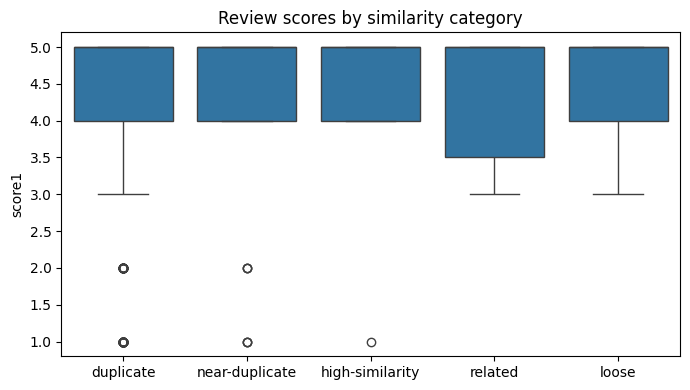

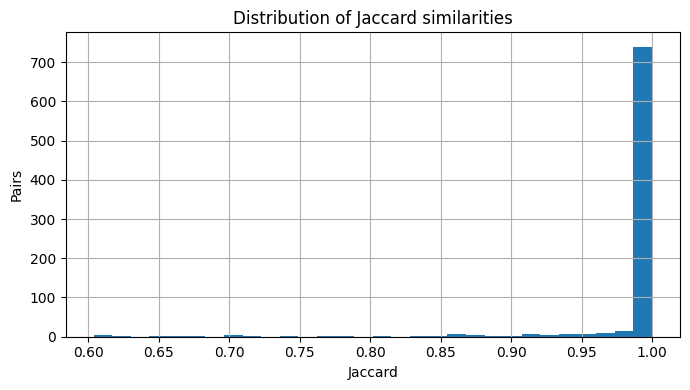

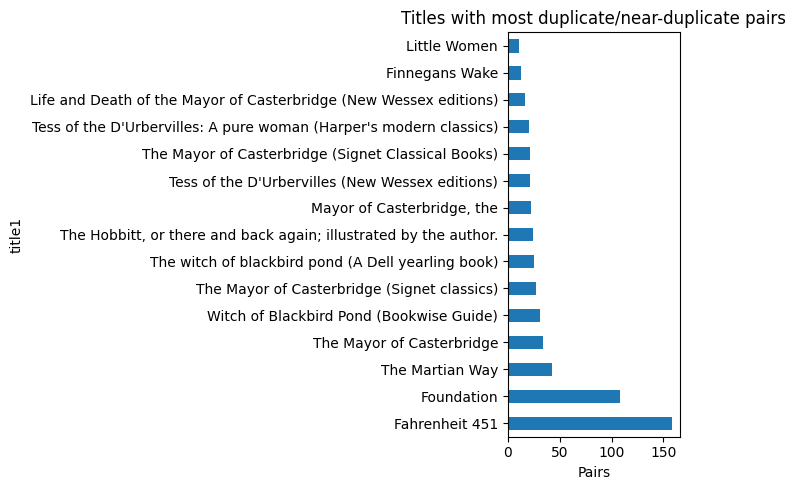

In [37]:

if not pairs_df.empty:
    plt.figure(figsize=(7,4))
    sns.boxplot(x="category", y="score1", data=pairs_df, order=["duplicate","near-duplicate","high-similarity","related","loose"])
    plt.title("Review scores by similarity category")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,4))
    pairs_df["jaccard"].hist(bins=30)
    plt.title("Distribution of Jaccard similarities")
    plt.xlabel("Jaccard")
    plt.ylabel("Pairs")
    plt.tight_layout()
    plt.show()

    top_titles = pairs_df.groupby("title1")["id1"].count().sort_values(ascending=False).head(15)
    plt.figure(figsize=(7,5))
    top_titles.plot(kind="barh", title="Titles with most duplicate/near-duplicate pairs")
    plt.xlabel("Pairs")
    plt.tight_layout()
    plt.show()

## Step 10 - Cross-Title Duplicate Check

For additional analysis, this section identifies cases where the **same text** appears under **different book titles**.  
These are clear examples of duplicate reviews that were likely copied across different books.  
The table below lists such instances.


In [38]:

if not pairs_df.empty:
    same_text_diff_books = pairs_df[
        (pairs_df["title1"] != pairs_df["title2"]) &
        (pairs_df["text1"] == pairs_df["text2"])
    ]
    print(f"\n Identical reviews across different titles: {len(same_text_diff_books)}")
    display(same_text_diff_books[["title1","title2","jaccard","text1","text2"]].head(10))


 Identical reviews across different titles: 395


,title1,title2,jaccard,text1,text2
1,Finnegans Wake,Finnegan's Wake,1.0,this book changed my life i love this book so much and think i understand all of it it means more to me than anything i have ever read i m just blown away by it because it is beautiful i ve never ...,this book changed my life i love this book so much and think i understand all of it it means more to me than anything i have ever read i m just blown away by it because it is beautiful i ve never ...
2,Foundation,The Martian Way,1.0,sociological insights into stimulating human progress foundation is the story of one man s attempt to positively influence human history beyond the grave for centuries to come set far in the futur...,sociological insights into stimulating human progress foundation is the story of one man s attempt to positively influence human history beyond the grave for centuries to come set far in the futur...
3,Tess of the D'Urbervilles (New Wessex editions),Tess of the D'Urbervilles: A pure woman (Harper's modern classics),1.0,suffering needlessly difficult read but captivatingsimpleton pure high ideal poverty makes mockery of high moral in all live as it were unfair to women,suffering needlessly difficult read but captivatingsimpleton pure high ideal poverty makes mockery of high moral in all live as it were unfair to women
6,"Three Nights in August: Strategy, Heartbreak, and Joy: Inside the Mind of a Manager","Three Nights in August: Strategy, Heartbreak, and Joy Inside the Mind of a Manager",1.0,baseball thru the manager s eyes this superb narrative shows us baseball from the eyes of the manager specifically readers come to know the mind and strategies of skipper tony la russa the backdro...,baseball thru the manager s eyes this superb narrative shows us baseball from the eyes of the manager specifically readers come to know the mind and strategies of skipper tony la russa the backdro...
7,Foundation,The Martian Way,1.0,not a foundation to isaac asimov s career the book foundation by isaac asimov has promise but leaves the reader without satisfaction upon completion though having what initially appears to be a gr...,not a foundation to isaac asimov s career the book foundation by isaac asimov has promise but leaves the reader without satisfaction upon completion though having what initially appears to be a gr...
9,The Mayor of Casterbridge,The Mayor of Casterbridge (Signet Classical Books),1.0,a general drama of pain though i expected sadness and misery i was hoping for something more profound at the ending than happiness was but the occasional episode in a general drama of pain this is...,a general drama of pain though i expected sadness and misery i was hoping for something more profound at the ending than happiness was but the occasional episode in a general drama of pain this is...
11,Tess of the D'Urbervilles: A pure woman (Harper's modern classics),Tess of the D'Urbervilles (New Wessex editions),1.0,lush landscapes and thought patterns by today s standards certain passages of this book may seem rather vague and subtle but they were shocking when first written enough that the book was subject ...,lush landscapes and thought patterns by today s standards certain passages of this book may seem rather vague and subtle but they were shocking when first written enough that the book was subject ...
12,Tess of the D'Urbervilles (New Wessex editions),Tess of the D'Urbervilles: A pure woman (Harper's modern classics),1.0,great classic great read had very few mistakes the tragedy and triumph in this story has always attracted me in a way that few stories have been able to do it will always be on my favorite read li...,great classic great read had very few mistakes the tragedy and triumph in this story has always attracted me in a way that few stories have been able to do it will always be on my favorite read li...
13,Foundation,The Martian Way,1.0,fantastic start a petition for a movie version more like 4 975 stars if we had more books like this